# Demand Prediction for Algorithmic and Dynamic Pricing Using Principal Components and Perceptrons

---
## Takeaways

This project focuses on forecasting demand as a component of dynamic and algorithmic pricing strategies.  
Using the Walmart Kaggle dataset, I applied deep learning methods to model department-level sales across multiple stores, while accounting for challenges such as holiday markdown events and the gap between observed sales and true latent demand.  

Key elements demonstrated in this notebook include:  
- Connecting demand forecasting to business applications like dynamic pricing  
- Applying statistical and machine learning techniques (PCA, perceptron algorithm, gradient descent variations)  
- Implementing and training neural networks in TensorFlow/Keras  
- Addressing challenges of high-dimensional modeling and external events (holidays, promotions)  

While this analysis focuses on demand forecasting rather than full prescriptive price optimization, it provides a foundation for integrating predictive modeling into pricing strategies in retail and e-commerce.

## Concepts I Explored

- **Linear feature extraction** with PCA  
- The **perceptron algorithm** (single-layer NN ≈ linear regression)  
- Basics of **Keras/TensorFlow**  
- Gradient descent variations: GD, SGD, batch, mini-batch  
- Understanding “learning” in deep learning  


In [ ]:
# Imports
import os
import os.path
import time
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import cvxpy as cp

tf.keras.utils.set_random_seed(42)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# setting data path
data_path = '/content/drive/My Drive/data'

---

# Introduction to Dynamic and Algorithmic Pricing Strategies

When I started looking into pricing strategies, I quickly realized that prices change far more often than I ever noticed before. Walmart, Amazon, Target — they all adjust prices constantly, sometimes minute by minute.  

This is **dynamic pricing** (sometimes called surge pricing, demand pricing, or time-based pricing). It used to be a niche tactic in airlines and travel, but now it’s everywhere in e-commerce.  

- **Example**: Amazon updates prices thousands of times per day to balance sales volume and profit margins.  
- Tools like [camelcamelcamel.com](https://camelcamelcamel.com) let us track these price swings over time.  

## Dynamic Pricing vs. Personalized Pricing

- **Dynamic pricing**  
  - Adjusts prices relative to the marketplace (cross-sectional)  
  - Does not require personal information  
  - Responds to supply and demand shifts  

- **Personalized pricing (differential pricing)**  
  - Adjusts prices for individuals based on history or behavior  
  - Often considered controversial or discriminatory  
  - May run into legal issues (e.g., Robinson-Patman Act of 1936)  

Dynamic pricing focuses on the market as a whole, while personalized pricing zooms in on individuals.  

## How Dynamic Pricing Affects a Business Model

I started thinking about dynamic pricing in terms of **key performance indicators (KPIs)**. A pricing algorithm doesn’t just set numbers — it changes how the entire business operates.  

**Obvious impacts:**  
- Revenue and profit margin  
- Inventory turnover (important for perishables)  
- Customer lifetime value (CLV)  
- Sales velocity  

**Less obvious impacts:**  
- Price-change frequency  
- Experimentation/testing rate  
- Expiration rates (food, fashion)  
- Website conversion rates  
- Overhead costs  

**Pricing levers impacted by algorithms:**  
- Base prices  
- Discounts and promotions  
- Bundles  
- Availability restrictions  
- Personalized offers and loyalty programs  

## Demand Forecasting as the Core

At the heart of all this lies **demand forecasting**.  

The optimal price $P_t^*$ depends on the forecasted demand $\hat{D}_t$ and other factors:  

$$
P_t^* = f(\hat{D}_t, \; \text{other factors})
$$

Other factors include:  
- Supply conditions  
- Market trends and competitor prices  
- Consumer expectations  
- Website/customer behavior  
- Purchase history  
- Inventory levels  
- Macroeconomic conditions  

A **price-optimization algorithm** brings these together:  
1. Forecast demand at various price points  
2. Apply business constraints (inventory, margins, etc.)  
3. Maximize revenue or profit  

## Sales as a Proxy for True Demand

One issue I came across is that **sales ≠ demand**. What we observe in transaction data is often biased:  

- **Spill demand** → demand lost when a product is out of stock  
- **Recaptured demand** → extra sales in substitute products still available  

If we ignore these effects:  
- Forecasts are **negatively biased** for stockout products  
- Forecasts are **positively biased** for substitutes  

A better formulation:  

$$
\text{True Demand} = \text{Observed Demand} + \text{Spill Demand} - \text{Recapture Demand} + \text{Noise}
$$

### Estimating True Demand

Because spill and recapture aren’t directly observed, we rely on **uncensoring methods**.  

- The **Expectation-Maximization (EM) Algorithm** is widely used:  
  - **E-step**: compute expected values of missing demand  
  - **M-step**: maximize likelihood to update parameters  
  - Iterate until convergence  

**Limitations:**  
- Many EM-based forecasts only adjust sales for individual SKUs  
- Substitution effects are often ignored, causing underestimation (spill) or overestimation (recapture) biases  

**Takeaway:** Observed sales are only a proxy. Correcting for spill/recapture is essential for accuracy.  

---

# Walmart Sales Data Project

For this project, I used the [Walmart Kaggle dataset](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting), which contains historical sales from 45 Walmart stores across regions.  

Each store has multiple departments → I forecast **department-level sales** over time.  

## Why Departments?

- Department sales act as a proxy for aggregate product demand  
- Easier to model than SKU-level noise  
- Still meaningful for pricing strategies  

## Formal Problem

Sales for store $i$, department $j$, time $t$:  

$$
Y_{i,j,t} = f_{\text{true}}(X_1, X_2, \dots, X_p)
$$  

We approximate with a deep learning model:  

$$
\hat{Y}_{i,j,t} = f_{\text{approx}, \lambda}(X_1, X_2, \dots, X_p; \beta)
$$  

We want:  

$$
Y_{i,j,t} \approx \hat{Y}_{i,j,t}
\;\;\;\;\Longleftrightarrow\;\;\;\;
\text{error}(\beta, \lambda) = |Y_{i,j,t} - \hat{Y}_{i,j,t}| \approx 0
$$  

## Training and Loss

- **Training** = finding parameters $(\beta, \lambda)$ that minimize aggregate error  
- Error is measured with a **loss function** across all samples  


## Challenge: Holiday Events

- Dataset includes **holiday markdown events**  
- These create unpredictable spikes in demand  
- It’s hard to know **which departments** will be affected and by **how much**  

---
## 1. Datasets

#### Dataset: features.csv  

This file contains contextual and regional data associated with Walmart store sales.  
It includes both store-level identifiers and external variables that may affect weekly sales.  

#### Contents  
- **Store number** – unique identifier for each store  
- **Week** – date of the observation  
- **Average Temperature** – average regional temperature (°F)  
- **Fuel Price** – average cost of fuel in the region  
- **MarkDown 1–5** – promotional markdown events run by Walmart  
  - Not available for all stores at all times  
  - Represent different types of promotions or discounts  
- **CPI (Consumer Price Index)** – captures regional price level  
- **Unemployment Rate** – regional unemployment measure  
- **Holiday Flag** – binary indicator for whether the week contains a major holiday  

#### Holiday Weeks in the Data  
- **Super Bowl**: 12-Feb-2010, 11-Feb-2011, 10-Feb-2012, 8-Feb-2013  
- **Labor Day**: 10-Sep-2010, 9-Sep-2011, 7-Sep-2012, 6-Sep-2013  
- **Thanksgiving**: 26-Nov-2010, 25-Nov-2011, 23-Nov-2012, 29-Nov-2013  
- **Christmas**: 31-Dec-2010, 30-Dec-2011, 28-Dec-2012, 27-Dec-2013  

> Note: Not all holiday dates are included across the dataset, and missing values in markdown features require careful preprocessing.


In [ ]:
features_data = pd.read_csv(os.path.join(data_path, 'features.csv'))

features_data.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


### Dataset: stores.csv  

This file contains anonymized information for the 45 Walmart stores in the dataset.  

#### Contents  
- **Store** – unique store identifier  
- **Type** – store type classification (e.g., A, B, C)  
- **Size** – square footage of the store  

> Note: Store type and size can be useful for modeling demand differences across locations (e.g., larger stores may serve higher volumes, while store type may capture assortment or format differences).  


In [ ]:
stores_data = pd.read_csv(os.path.join(data_path, 'stores.csv'))

stores_data.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
stores_data['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [ ]:
stores_data['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

### Dataset: train.csv  

This file contains the labels for the training data, covering the period **2010-02-05 to 2012-11-01**.  

#### Contents  
- **Store** – store identifier  
- **Dept** – department identifier  
- **Date** – weekly time stamp  
- **Weekly_Sales** – sales for the given department in the given store  
- **IsHoliday** – binary indicator for whether the week corresponds to a special holiday (Super Bowl, Labor Day, Thanksgiving, Christmas)  


In [ ]:
train_data = pd.read_csv(os.path.join(data_path, 'train.csv'))

train_data.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [ ]:
features_data.shape, stores_data.shape, train_data.shape

((8190, 12), (45, 3), (421570, 5))

In [ ]:
data = pd.merge(features_data, stores_data, on=["Store"], how="outer")

data = pd.merge(data, train_data, on=["Store", "Date", "IsHoliday"], how="inner")

data

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,1,24924.50
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2,50605.27
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,3,13740.12
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,4,39954.04
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,32229.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,93,2487.80
421566,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,94,5203.31
421567,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,95,56017.47
421568,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,97,6817.48


---
## 2. Data Cleaning

### Splitting the Data into Training and Testing Sets

We will use a **time-series split**: the training set contains observations that occur **before** the testing set. This preserves temporal order and prevents information from the future leaking into the past.

#### Preventing Data Leakage (Lookahead Bias)

To avoid predicting with information from the same period, we shift the features by one period so that we predict $Y_t$ using $X_{t-1}$ (not $X_t$):

- **Goal:** predict $Y_t$ with **lagged** features $X_{t-1}$  
- **Implementation:** apply a one-step lag to all predictive features

Formally:
$$
\widehat{Y}_t = f\!\big(X_{t-1}\big)
$$

#### Practical Steps

1. **Sort by time** (and by store/department keys if applicable).  
2. **Create lagged features**: for each feature column $X$, compute $X^{(\text{lag1})} = \text{shift}(X, 1)$.  
3. **Drop the first period** after shifting (it will have missing values).  
4. **Choose the split point** (a cutoff date) and assign **all dates < cutoff** to train and **$\ge$ cutoff** to test.  
5. **(Optional)** Use rolling/expanding validations for model selection.

In [ ]:
data.shape

(421570, 16)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Date          421570 non-null  object 
 2   Temperature   421570 non-null  float64
 3   Fuel_Price    421570 non-null  float64
 4   MarkDown1     150681 non-null  float64
 5   MarkDown2     111248 non-null  float64
 6   MarkDown3     137091 non-null  float64
 7   MarkDown4     134967 non-null  float64
 8   MarkDown5     151432 non-null  float64
 9   CPI           421570 non-null  float64
 10  Unemployment  421570 non-null  float64
 11  IsHoliday     421570 non-null  bool   
 12  Type          421570 non-null  object 
 13  Size          421570 non-null  int64  
 14  Dept          421570 non-null  int64  
 15  Weekly_Sales  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

data

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
Date,,,,,,,,,,,,,,,
2010-02-05,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,1,24924.50
2010-02-05,35,27.19,2.784,NaN,NaN,NaN,NaN,NaN,135.352461,9.262,False,B,103681,3,14612.19
2010-02-05,35,27.19,2.784,NaN,NaN,NaN,NaN,NaN,135.352461,9.262,False,B,103681,4,26323.15
2010-02-05,35,27.19,2.784,NaN,NaN,NaN,NaN,NaN,135.352461,9.262,False,B,103681,5,36414.63
2010-02-05,35,27.19,2.784,NaN,NaN,NaN,NaN,NaN,135.352461,9.262,False,B,103681,6,11437.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,13,46.97,3.755,10192.49,364.57,150.0,1714.15,5563.92,131.193097,5.621,False,A,219622,49,7770.71
2012-10-26,13,46.97,3.755,10192.49,364.57,150.0,1714.15,5563.92,131.193097,5.621,False,A,219622,50,1486.00
2012-10-26,13,46.97,3.755,10192.49,364.57,150.0,1714.15,5563.92,131.193097,5.621,False,A,219622,52,4738.93


In [ ]:
# An approximate 70/30 Time Series Split

training_data = data.loc[:'2011', :].copy()

testing_data = data.loc['2012':, :].copy()

In [ ]:
training_data.tail()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
Date,,,,,,,,,,,,,,,
2011-12-30,19,31.65,3.566,6234.22,50438.17,210.34,1457.96,2373.94,136.643258,7.866,True,A,203819,32,12122.50
2011-12-30,19,31.65,3.566,6234.22,50438.17,210.34,1457.96,2373.94,136.643258,7.866,True,A,203819,33,4875.31
2011-12-30,19,31.65,3.566,6234.22,50438.17,210.34,1457.96,2373.94,136.643258,7.866,True,A,203819,34,12897.00
2011-12-30,20,36.35,3.389,6918.65,97740.99,270.38,1648.03,2852.19,212.403576,7.082,True,A,203742,26,9847.01
2011-12-30,20,36.35,3.389,6918.65,97740.99,270.38,1648.03,2852.19,212.403576,7.082,True,A,203742,25,15816.08


In [ ]:
testing_data.head()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
Date,,,,,,,,,,,,,,,
2012-01-06,26,22.94,3.439,3352.77,17442.27,117.1,468.31,6344.32,136.698129,7.467,False,A,152513,48,117.00
2012-01-06,26,22.94,3.439,3352.77,17442.27,117.1,468.31,6344.32,136.698129,7.467,False,A,152513,49,1920.57
2012-01-06,26,22.94,3.439,3352.77,17442.27,117.1,468.31,6344.32,136.698129,7.467,False,A,152513,52,946.36
2012-01-06,26,22.94,3.439,3352.77,17442.27,117.1,468.31,6344.32,136.698129,7.467,False,A,152513,55,10478.94
2012-01-06,26,22.94,3.439,3352.77,17442.27,117.1,468.31,6344.32,136.698129,7.467,False,A,152513,56,168.69


In [ ]:
training_data[['Store', 'Dept']].value_counts().sort_index().unstack()

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,79.0,100.0,100.0,15.0
2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,17.0
3,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,NaN,33.0,100.0,100.0,97.0,23.0,NaN
4,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,17.0
5,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,NaN,49.0,100.0,100.0,84.0,11.0,NaN
6,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,17.0
7,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,73.0,100.0,100.0,100.0,98.0,NaN
8,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,NaN,100.0,100.0,13.0
9,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,2.0,46.0,100.0,100.0,9.0,11.0,NaN


In [ ]:
testing_data[['Store', 'Dept']].value_counts().unstack()

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,22.0
2,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,25.0
3,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,NaN,21.0,43.0,43.0,43.0,13.0,NaN
4,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,25.0
5,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,NaN,25.0,43.0,43.0,43.0,12.0,NaN
6,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,23.0
7,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,43.0,42.0,43.0,43.0,43.0,43.0,1.0
8,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,43.0,43.0,43.0,3.0,43.0,43.0,22.0
9,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,43.0,43.0,43.0,NaN,28.0,43.0,43.0,NaN,3.0,NaN


### Imputing Null Values on Training and Testing Sets

Handling missing values is a crucial preprocessing step, but in a **time-series prediction setting** we must ensure that our imputation method does not cause **data leakage (lookahead bias)**.

#### Key Principle  
When imputing values in the **testing set**, we can only use information available **from the training set**.  
This ensures that the model never has access to future information.

#### Practical Strategy  

1. **Compute statistics (mean, median, mode, etc.) on the training set only.**  
2. **Apply these statistics to impute missing values** in both the training and testing sets.  
   - Training set → imputed using its own statistics  
   - Testing set → imputed using the training set’s statistics (not test data itself)  


In [ ]:
data.isna().sum()

,0
Store,0
Temperature,0
Fuel_Price,0
MarkDown1,270889
MarkDown2,310322
MarkDown3,284479
MarkDown4,286603
MarkDown5,270138
CPI,0
Unemployment,0


In [ ]:
training_data.isna().sum()

,0
Store,0
Temperature,0
Fuel_Price,0
MarkDown1,270432
MarkDown2,273978
MarkDown3,271016
MarkDown4,273090
MarkDown5,270138
CPI,0
Unemployment,0


In [ ]:
testing_data.isna().sum()

,0
Store,0
Temperature,0
Fuel_Price,0
MarkDown1,457
MarkDown2,36344
MarkDown3,13463
MarkDown4,13513
MarkDown5,0
CPI,0
Unemployment,0


<Axes: xlabel='Date'>

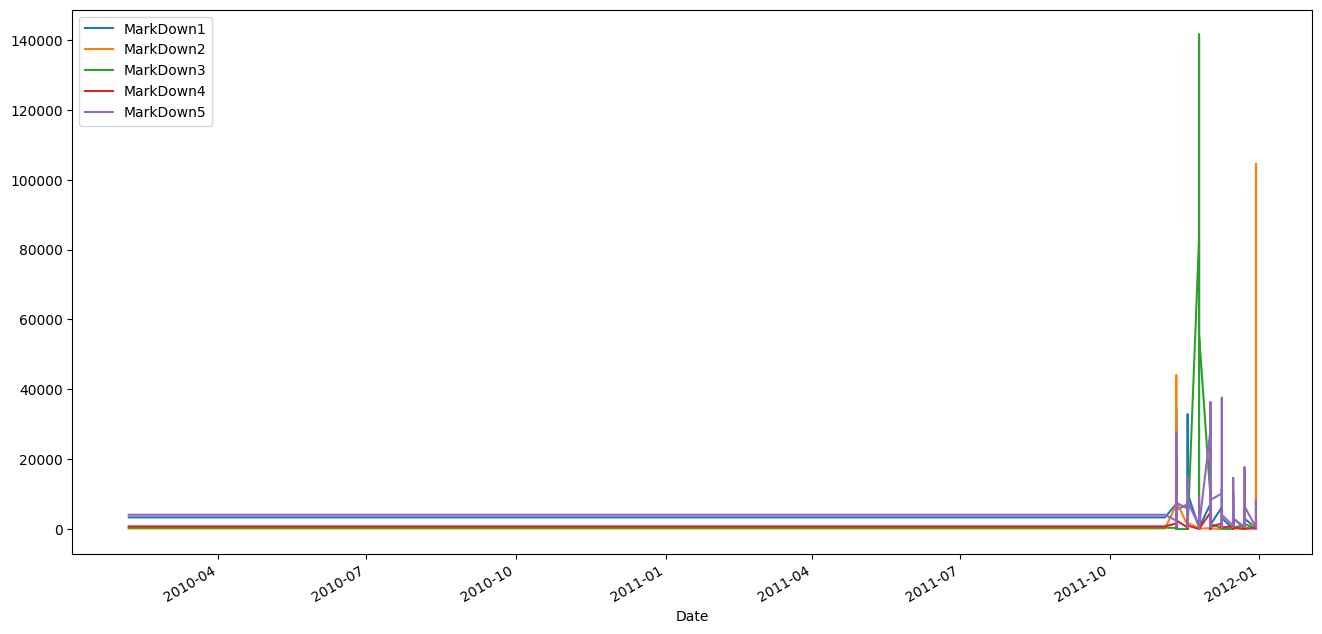

In [ ]:
training_data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(training_data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].median()).plot(figsize=(16,8))

<Axes: xlabel='Date'>

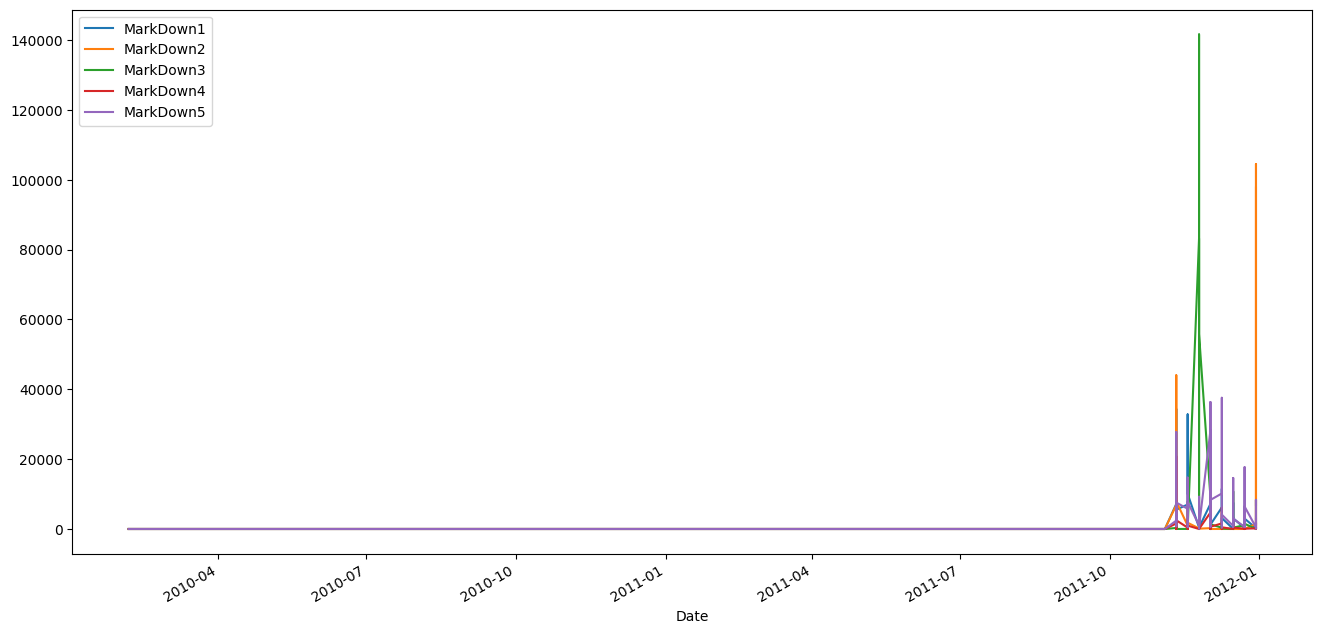

In [ ]:
training_data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(0).plot(figsize=(16,8))

We must be very careful to avoid **data leakage** when filling in missing values. Any imputation should only rely on information available at the time of prediction.  

### MarkDown Columns  
The `MarkDown1`–`MarkDown5` variables represent promotional discounts that Walmart occasionally runs.  

- When these values are missing, the natural interpretation is that **no markdown event took place** during that week.  
- Therefore, we can **safely fill missing values with `0`** for all MarkDown columns.  
- This assumption both prevents leakage and keeps the meaning of the feature consistent.  


In [ ]:
training_data.fillna(0, inplace=True)

In [ ]:
testing_data.fillna(0, inplace=True)

---
## 3. Exploratory Data Analysis (EDA) and Descriptive Analytics on the Training Set  

At this step, we want to explore the **sales variable** and its relationship with other features in the dataset.  

To avoid **lookahead bias** when evaluating generalization error, we will restrict our descriptive analysis to the **training set only**. This ensures that no future information leaks into the modeling process.  

### Why EDA Matters  
Performing EDA allows us to:  
- **Identify patterns** in the data that guide model selection and improve predictive performance.  
- **Spot anomalies or biases** that could mislead the model if left untreated.  
- **Generate new features** (feature engineering) that extract additional signal from the raw data.  
- **Understand variable distributions** (sales, CPI, unemployment, markdowns, holidays, etc.) to inform preprocessing choices.  

### Connecting to Modeling  
- Insights from EDA help us decide which **class of models** may perform best (linear, tree-based, deep learning).  
- Feature engineering guided by EDA can directly improve prediction accuracy.  
- Later in the workflow, we will see how **deep learning automates feature extraction**, capturing nonlinear and high-dimensional patterns that manual methods may miss.  

This stage bridges the raw data with structured modeling, ensuring our predictive pipeline is both **robust** and **data-driven**.  


In [ ]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,294132.0,22.180178,12.780170,1.000,11.000000,22.000000,33.000000,45.000000
Temperature,294132.0,58.909079,18.934062,-2.060,45.260000,60.420000,73.340000,100.140000
Fuel_Price,294132.0,3.209664,0.439060,2.472,2.808000,3.129000,3.595000,4.211000
MarkDown1,294132.0,365.333355,1934.134759,0.000,0.000000,0.000000,0.000000,34348.140000
MarkDown2,294132.0,535.068938,5193.032485,0.000,0.000000,0.000000,0.000000,104519.540000
MarkDown3,294132.0,649.096663,6610.541248,-0.870,0.000000,0.000000,0.000000,141630.610000
MarkDown4,294132.0,109.561983,695.518638,0.000,0.000000,0.000000,0.000000,20834.370000
MarkDown5,294132.0,521.536105,2698.759858,0.000,0.000000,0.000000,0.000000,37581.270000
CPI,294132.0,169.529527,38.464447,126.064,131.901968,182.077986,211.096358,223.249677
Unemployment,294132.0,8.232486,1.865189,4.420,7.287000,8.058000,8.684000,14.313000


<Axes: ylabel='Frequency'>

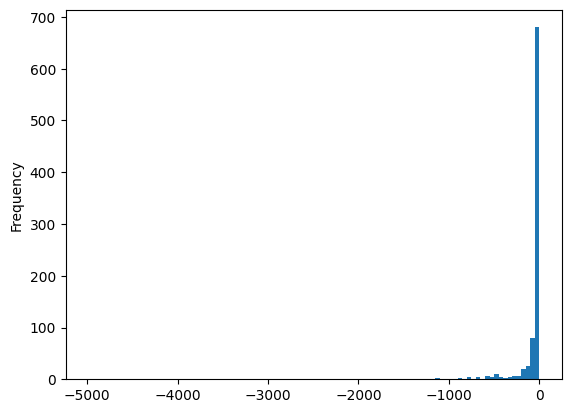

In [ ]:
training_data.loc[training_data['Weekly_Sales']<0, 'Weekly_Sales'].plot(kind='hist', bins=100)

In [ ]:
# We will only keep rows where we have nonnegative weekly sales, as this is a data error

training_data = training_data[training_data['Weekly_Sales']>=0]

testing_data = testing_data[testing_data['Weekly_Sales']>=0]

In [ ]:
training_data['Weekly_Sales'].describe().T

,Weekly_Sales
count,293259.000000
mean,16153.473574
std,22978.445289
min,0.000000
25%,2179.585000
50%,7775.200000
75%,20412.780000
max,693099.360000


<Axes: ylabel='Frequency'>

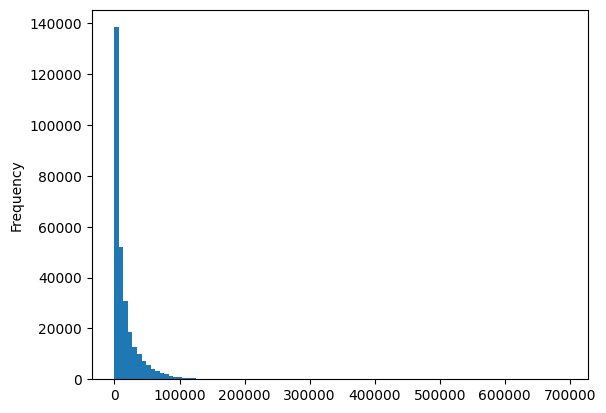

In [ ]:
training_data['Weekly_Sales'].plot(kind='hist', bins=100)

<Axes: >

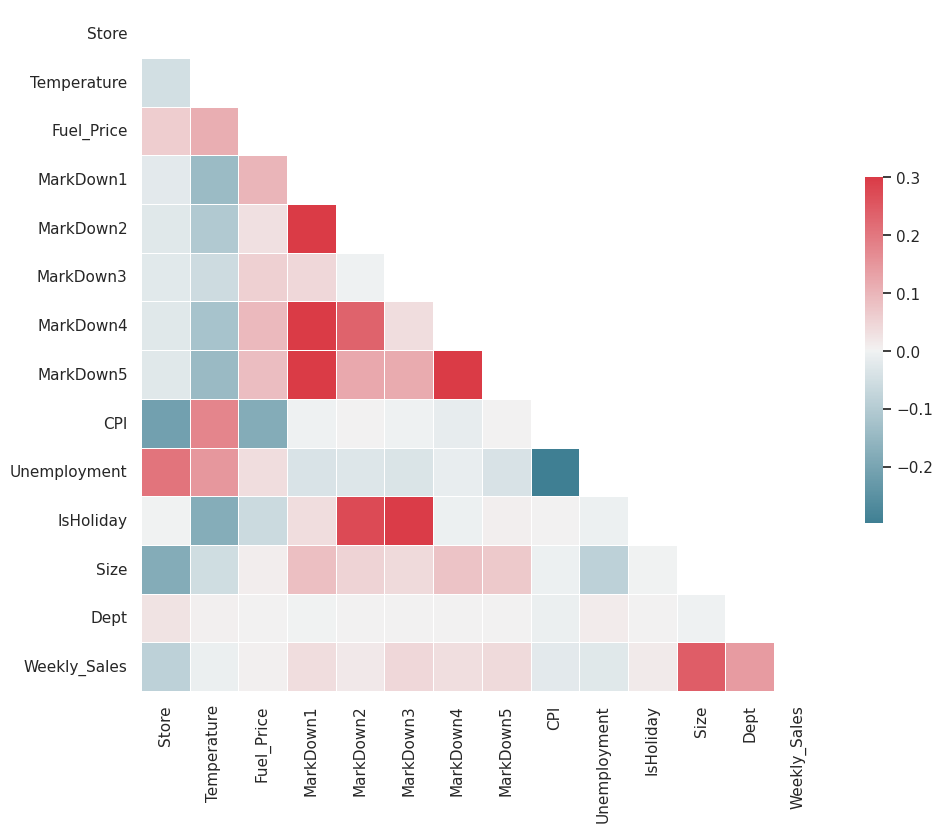

In [ ]:
sns.set(style="white")

# Compute the correlation matrix
corr = training_data.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Initial Observations from Correlation Analysis  

From the correlation table, most findings are fairly expected:  

- **Discounts** (Markdown features) are positively correlated with sales.  
- **Unemployment** is negatively correlated with the **Consumer Price Index (CPI)**.  
- **Store size** has a strong positive relationship with sales.  
- **Unemployment** also shows a slight negative correlation with sales.  

Some more interesting patterns include:  
- **Higher department numbers** tend to correspond to higher sales — possibly because they represent newer or larger departments.  
- **Discount events** generally push sales upward.  

On the other hand, some variables appear to have **little or no relationship with weekly sales**:  
- **Holidays** (at least as represented in the data)  
- **Temperature**  
- **Fuel prices**  

#### Next Step  
We will **visualize these relationships** to get a clearer picture of how different features interact with sales. Plots will help confirm whether these observed correlations hold in practice and reveal any nonlinear trends not captured by the correlation matrix.  


<Axes: xlabel='Fuel_Price', ylabel='Weekly_Sales'>

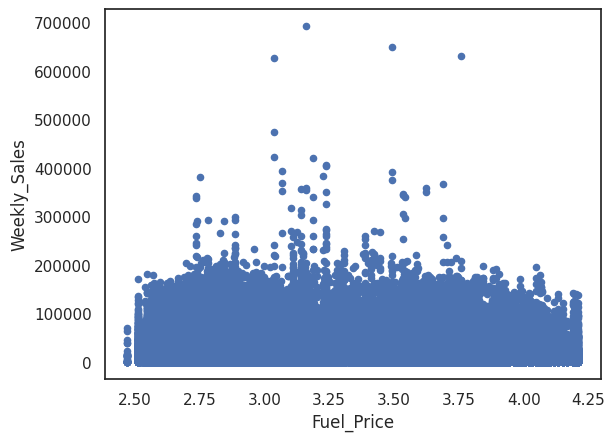

In [ ]:
training_data.plot.scatter(x='Fuel_Price', y='Weekly_Sales')

<Axes: xlabel='Temperature', ylabel='Weekly_Sales'>

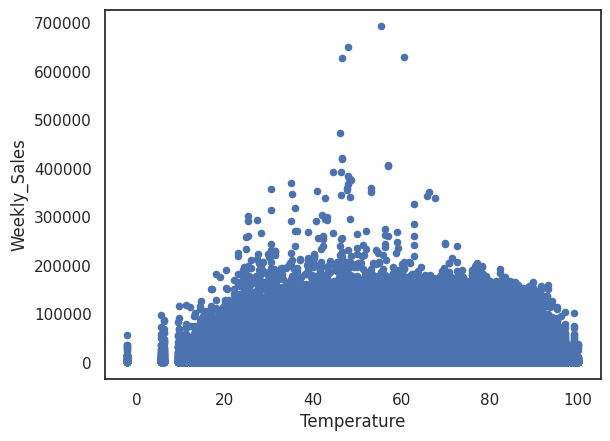

In [ ]:
training_data.plot.scatter(x='Temperature', y='Weekly_Sales')

<Axes: xlabel='Size', ylabel='Weekly_Sales'>

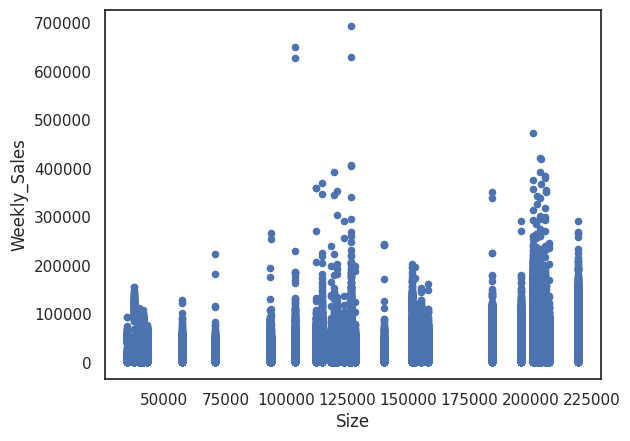

In [ ]:
training_data.plot.scatter(x='Size', y='Weekly_Sales')

<Axes: xlabel='Store', ylabel='Weekly_Sales'>

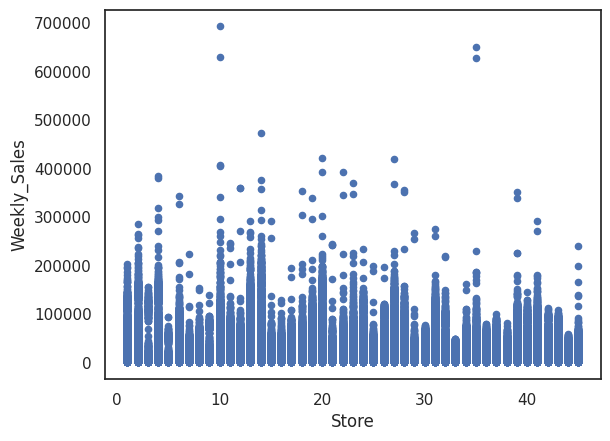

In [ ]:
training_data.plot.scatter(x='Store', y='Weekly_Sales')

<Axes: xlabel='Type', ylabel='Weekly_Sales'>

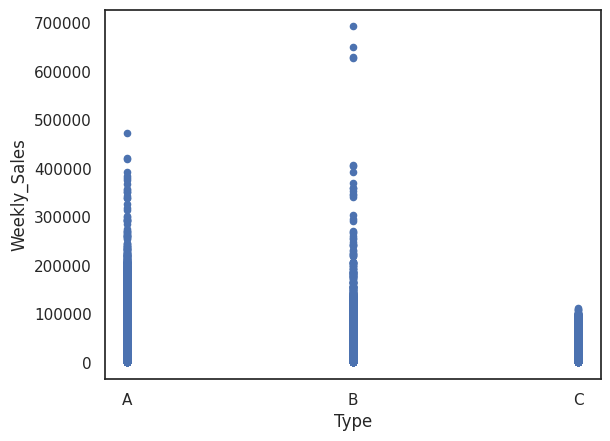

In [ ]:
training_data.plot.scatter(x='Type', y='Weekly_Sales')

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

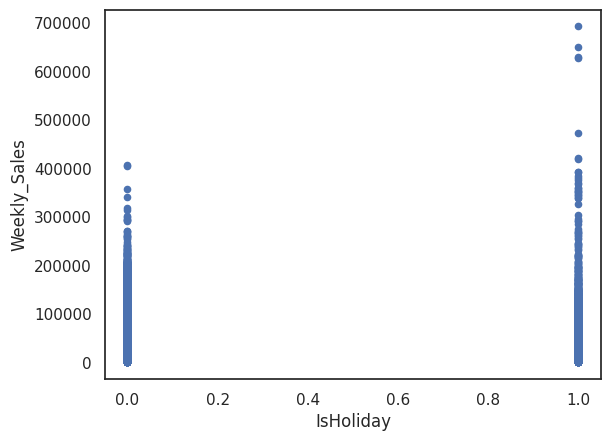

In [ ]:
training_data['IsHoliday'] = np.where(training_data['IsHoliday'], 1, 0)
testing_data['IsHoliday'] = np.where(testing_data['IsHoliday'], 1, 0)

training_data.plot.scatter(x='IsHoliday', y='Weekly_Sales')

### Further Observations  

- **Store Type C** consistently shows **lower overall sales** compared to Types A and B.  
- **Holidays** clearly drive **spikes in sales**, confirming the importance of discount events and seasonal effects.  

Other than these patterns, no strong additional relationships emerge from this analysis.  

#### Outliers  
However, we do notice the presence of **outliers** in the sales data.  
These extreme values may be driven by:  
- Special events (e.g., Black Friday, holiday promotions).  
- Data entry errors or missing adjustments.  
- Unique regional or store-level effects.  

We will take a **closer look at these outliers** to determine whether they represent genuine business events (which we should model) or anomalies/noise (which may need to be treated).  


In [ ]:
# Do we notice any patterns?

training_data.loc[training_data['Weekly_Sales'] > 300_000]

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
Date,,,,,,,,,,,,,,,
2010-11-26,20,46.66,3.039,0.00,0.00,0.00,0.00,0.00,204.962100,7.484,1,A,203742,72,422306.25
2010-11-26,18,40.81,3.070,0.00,0.00,0.00,0.00,0.00,132.836933,9.331,1,B,120653,72,353008.64
2010-11-26,4,48.08,2.752,0.00,0.00,0.00,0.00,0.00,126.669267,7.127,1,A,205863,72,381072.11
2010-11-26,27,46.67,3.186,0.00,0.00,0.00,0.00,0.00,136.689571,8.021,1,A,204184,72,420586.57
2010-11-26,12,47.66,3.162,0.00,0.00,0.00,0.00,0.00,126.669267,14.313,1,B,112238,72,359995.60
2010-11-26,28,47.66,3.162,0.00,0.00,0.00,0.00,0.00,126.669267,14.313,1,A,206302,72,355356.39
2010-11-26,10,55.33,3.162,0.00,0.00,0.00,0.00,0.00,126.669267,9.003,1,B,126512,72,693099.36
2010-11-26,6,65.79,2.735,0.00,0.00,0.00,0.00,0.00,213.267296,7.007,1,A,202505,72,342578.65
2010-11-26,14,46.15,3.039,0.00,0.00,0.00,0.00,0.00,182.783277,8.724,1,A,200898,72,474330.10


### Detecting Special Event Patterns  

We notice a **clear pattern** in the data:  

- **Black Friday (end of November)** consistently shows **exceptionally high sales spikes**.  
  - This suggests that Black Friday should be explicitly accounted for.  
  - We will create a **dummy variable** to capture this effect.  

- **Christmas** also shows strong sales activity, but it is **not classified as a holiday** in the dataset.  
  - We will also create a **dummy variable for Christmas week**.  

We will now check if there are **other recurring special events** that systematically affect sales.  
If found, we will create **dummy variables** for them as well, to ensure the model captures these seasonal demand shocks.  


In [ ]:
training_data.loc[training_data['Weekly_Sales'] >240_000].index.value_counts()

,count
Date,
2010-11-26,23
2011-11-25,22
2010-12-24,14
2011-12-23,9
2010-12-17,2
2010-02-05,1
2011-08-26,1


---
## 4. Feature Engineering: Special Event Variables  

After reviewing the data, we find that **only a few events consistently impact sales**:  

- **Black Friday**  
- **Two days before Christmas**  

Aside from a handful of spurious spikes, these events appear to be the **most reliable drivers of exceptional sales activity**.  

We will now move into **feature engineering**, creating new variables that encode stronger predictive signals for the sales target.  
This process should help the model better capture important seasonal and event-driven demand patterns.  


### Deriving Features for Forecasting Demand  

A key step in forecasting is **feature engineering**, where we create new variables that better capture the patterns in the data.  
While we could spend significant time designing complex interactions, for this project we will focus on straightforward yet powerful transformations.  

#### Categorical Variables → Dummy Variables  
- Encode **store-specific categories** and the **holiday indicator** into dummy (indicator) variables.  
- Encode **month of the year** into **12 dummy variables** (one per month).  

**Note:** To avoid the *dummy variable trap* (perfect collinearity), we should:  
- Either remove one category dummy, **or**  
- Fit the regression without an intercept.  
- This issue is most critical for **linear regression models**.  

#### Special Event Variables  
- Create dummy variables for **Christmas** and **Black Friday**.  
- For Black Friday, we hard-code the dates within our sample:  
  - 11/25/2011  
  - 11/26/2012  

#### Normalization of Numerical Features  
- Normalize continuous predictors by converting them into **Z-scores**:  

$$
Z = \frac{X - \mu}{\sigma}
$$

This ensures features are on a similar scale, which is especially important for gradient-based algorithms like neural networks.  


In [ ]:
# Make sure we can later recognize what a dummy once belonged to

training_testing_data = [training_data, testing_data]

for df in training_testing_data:
  df['Type'] = 'Type_' + df['Type'].map(str)
  df['Store'] = 'Store_' + df['Store'].map(str)
  df['Dept'] = 'Dept_' + df['Dept'].map(str)
  df['IsHoliday'] = 'IsHoliday_' + df['IsHoliday'].map(str)

  df['Month'] = 'Month_' + df.index.month.map(str)

  df['Black_Friday'] = np.where((df.index==datetime(2010, 11, 26).date()) | (df.index==datetime(2011, 11, 25).date()), 'yes', 'no')
  df['Pre_Christmas'] = np.where((df.index==datetime(2010, 12, 23).date()) | (df.index==datetime(2010, 12, 24).date()) | (df.index==datetime(2011, 12, 23).date()) | (df.index==datetime(2011, 12, 24).date()), 'yes', 'no')
  df['Black_Friday'] = 'Black_Friday_' + df['Black_Friday'].map(str)
  df['Pre_Christmas'] = 'Pre_Christmas_' + df['Pre_Christmas'].map(str)

In [ ]:
# Create dummies for store features and for holiday indicator

for df, i in zip(training_testing_data, range(2)):
  type_dummies = pd.get_dummies(df['Type'], drop_first=True, dtype=float)
  store_dummies = pd.get_dummies(df['Store'], drop_first=True, dtype=float)
  dept_dummies = pd.get_dummies(df['Dept'], drop_first=True, dtype=float)
  holiday_dummies = pd.get_dummies(df['IsHoliday'], drop_first=True, dtype=float)

  month_dummies = pd.get_dummies(df['Month'], drop_first=True, dtype=float)

  Black_Friday_dummies = pd.get_dummies(df['Black_Friday'], drop_first=True, dtype=float)
  Pre_christmas_dummies = pd.get_dummies(df['Pre_Christmas'], drop_first=True, dtype=float)

  if i == 1:
    # Nov, Dec are not in the testing sample, so we must add the columns manually
    df['Month_11'] = 0
    df['Month_12'] = 0

  training_testing_data[i] = pd.concat([df,
                                        type_dummies, store_dummies, dept_dummies, holiday_dummies,
                                        month_dummies,
                                        Black_Friday_dummies, Pre_christmas_dummies],
                                        axis=1)

In [ ]:
training_data = training_testing_data[0]

testing_data = training_testing_data[1]

In [ ]:
# Normalize the numerical variables using means and stds from the TRAINING DATA
for df in training_testing_data:
  df[['Unemployment', 'Temperature', 'Fuel_Price', 'CPI', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = (df[['Unemployment', 'Temperature', 'Fuel_Price', 'CPI', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] - training_testing_data[0][['Unemployment', 'Temperature', 'Fuel_Price', 'CPI', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].mean())/(training_testing_data[0][['Unemployment', 'Temperature', 'Fuel_Price', 'CPI', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].std())


In [ ]:
training_data.isna().sum().sum(), testing_data.isna().sum().sum()

(np.int64(0), np.int64(0))

In [ ]:
training_data.shape, testing_data.shape

((293259, 156), (127026, 156))

<Axes: >

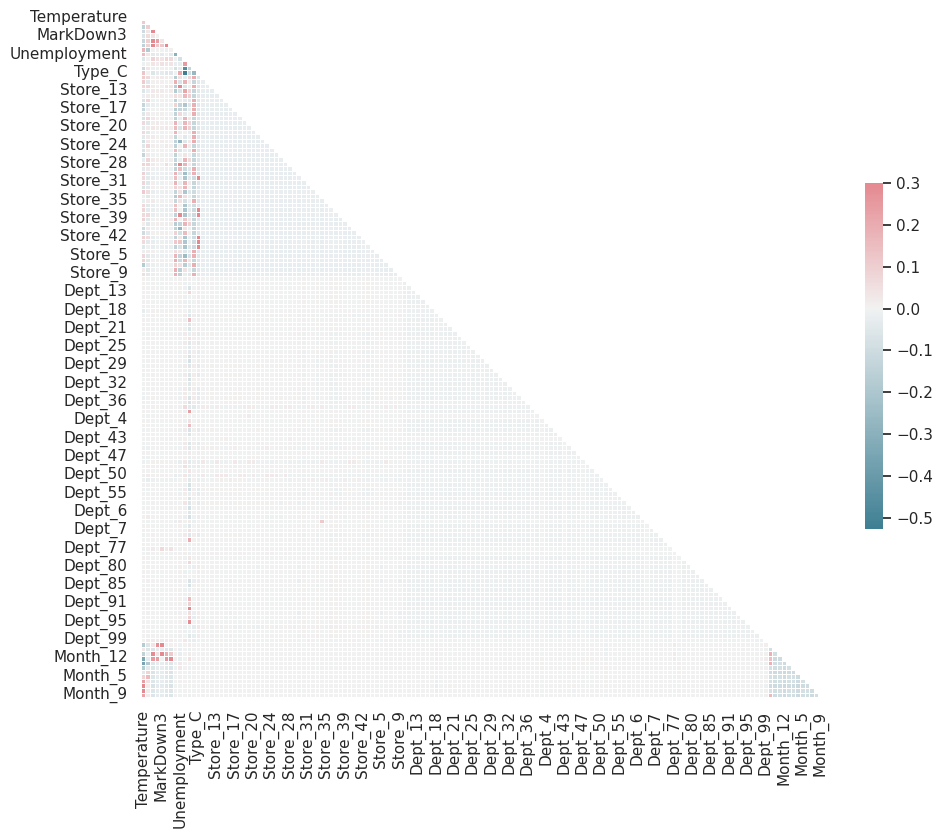

In [ ]:
# How can we select the variables that we think are most important?
sns.set(style="white")

# Compute the correlation matrix
corr = training_data.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
np.abs(training_data.corr(numeric_only=True)[['Weekly_Sales']]).sort_values(by='Weekly_Sales', ascending=False).head(20)

,Weekly_Sales
Weekly_Sales,1.000000
Dept_92,0.313437
Dept_95,0.288222
Size,0.242893
Dept_38,0.240762
Dept_72,0.196681
Dept_90,0.155331
Dept_40,0.153379
Dept_2,0.148335
Type_B,0.128456


In [ ]:
# Let's separate our data into X and Y

X_train = training_data[training_data.columns.drop('Weekly_Sales')].select_dtypes(include=np.number)
Y_train = training_data[['Weekly_Sales']]

X_test = testing_data[testing_data.columns.drop('Weekly_Sales')].select_dtypes(include=np.number)
Y_test = testing_data[['Weekly_Sales']]

In [ ]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((293259, 148), (127026, 148), (293259, 1), (127026, 1))

### Selecting Variables for Prediction  

Up to this point, we have relied on **manual feature engineering** (e.g., dummy variables for months, holidays, store types, etc.).  
But the key question remains:  

**Which variables should we actually use to predict future weekly sales per store and per department?**  

Manually selecting features can be time-consuming and prone to bias. Instead, we can turn to **algorithmic solutions** that automate feature selection or extraction.  

#### Approaches to Feature Selection / Extraction  
1. **Filter methods** – rank features based on statistical measures (e.g., correlation with sales, mutual information).  
2. **Wrapper methods** – iteratively test subsets of features (e.g., recursive feature elimination).  
3. **Embedded methods** – use models that inherently perform feature selection (e.g., LASSO, tree-based models).  
4. **Representation learning** – use algorithms like **Principal Component Analysis (PCA)** or **neural networks** to automatically extract new features from the raw data.  

We will explore an **algorithmic solution to feature engineering**, where the model itself learns the best representation of the data.  
This shifts the burden of manually crafting features toward **letting the model discover structure** in the data.  


---
## 5. Using Principal Components to Learn Features  

Principal Components Analysis (PCA) is a powerful **algorithmic feature generation** method.  
It reduces dimensionality by projecting high-dimensional data into lower-dimensional subspaces, while preserving as much variance as possible.  

### Key Idea  
PCA learns **new features** (principal components) that capture the maximum variation in the data:  

$$
(Z_1, Z_2, \dots, Z_p)
$$

Each principal component is a **linear combination** of the original variables:  

$$
Z_i = w_{i1}X_1 + w_{i2}X_2 + \dots + w_{ip}X_p
$$

These new features are:  
- **Uncorrelated (orthogonal):**  
  $$
  \text{Corr}(Z_i, Z_j) = 0 \quad \text{for } i \neq j
  $$  
- **Ranked by variance explained:**  
  $$
  \text{Var}(Z_1) \geq \text{Var}(Z_2) \geq \dots \geq \text{Var}(Z_p)
  $$  

### How PCA Works  
1. **Center the data:** subtract the mean from each feature.  
2. **Compute covariance matrix:**  
   $$
   \hat{C} = \frac{1}{n} \tilde{X}^T \tilde{X}
   $$  
   where $tilde{X} = X - E[X]$.  

3. **Eigen-decompose the covariance matrix:**  
   $$
   \hat{C} = O \Lambda O^T = \sum_{i=1}^p \lambda_i o_i o_i^T
   $$  
   - $O$: orthogonal matrix of eigenvectors (directions).  
   - $Lambda = \text{diag}(\lambda_1, \dots, \lambda_p$: eigenvalues (variance explained).  

4. **Project data onto eigenvectors:**  
   $$
   Z = X O
   $$  
   giving us the principal components.  

### Interpretation  
- Each **principal component** is just a **linear combination** of the original features.  
- The **leading eigenvalues** \$lambda_i$ show which directions (components) explain the most variation in the data.  

PCA is often the first step in building **algorithmic feature sets**, enabling models to work with lower-dimensional, less correlated representations of the data.  


### What is Learning?

In machine learning, **learning** means finding the set of parameters (weights) that minimize a loss function.  
The process is iterative: the model makes predictions, compares them to actual values, and updates its parameters to reduce error.

Formally, we want to minimize the expected loss:

$$
L(w; X, Y) = \mathbb{E}\big[\ell(w; (X_1, \dots, X_p, Y))\big]
\;\;\approx\;\; \frac{1}{n}\sum_{i=1}^n \ell\big(w; (x_{i,1}, \dots, x_{i,p}, y_i)\big)
$$

where:
- $ w $ = parameters (sometimes written as \( \beta \) or \( \theta \))  
- $ L $ = loss function  
- $ (x_i, y_i) $ = observed data points  

### Common Loss Functions
- **Regression (continuous targets):**
$$
L(w) = \frac{1}{n}\sum_{i=1}^n \big(y_i - \hat{y}_i\big)^2
$$
(MSE: mean squared error)

- **Classification (categorical targets):**
$$
L(w) = -\frac{1}{n}\sum_{i=1}^n \sum_{k=1}^K y_{i,k} \log(\hat{p}_{i,k})
$$
(Cross-entropy / log-loss)

### Optimization Problem
All machine learning boils down to solving:
$$
\hat{w} = \arg\min_w L(w; X, Y)
$$

When we find \(\hat{w}\), the model is said to have **learned** from the data.  
The standard way to solve this is through **gradient descent**, where derivatives of the loss function guide parameter updates.

---
## 6. Implementing PCA as a Neural Network

Principal Components Analysis (PCA) is usually implemented with:
- Scikit-Learn (SVD-based),
- NumPy (eigendecomposition),
- or, interestingly, **as a linear autoencoder** in deep learning frameworks like TensorFlow/Keras.

### Autoencoder Structure
- **Encoder:** maps input data to a lower-dimensional latent representation.  
- **Decoder:** reconstructs the input from this latent space.  
- **Reconstruction loss:** penalizes differences between inputs and outputs.

If the latent space has **lower dimensionality** than the input (an undercomplete autoencoder), the network is forced to capture only the most important patterns in the data.

### Connection to PCA
- If all layers are **linear** and the loss is **MSE**,  
the autoencoder essentially performs PCA.  
This makes it a neat way to express PCA within a deep learning workflow.

In practice:
- Inputs → Encoder (linear projection) → Latent space  
- Latent space → Decoder → Reconstruction  
- Minimize reconstruction error (MSE)  
- Latent vectors ≈ principal components

### Linear Autoencoder (PCA-style Feature Learner)

We build a **linear autoencoder** to learn low-dimensional features (PCA-style):
- **Encoder**: single `Dense(k)` layer (linear, no activation) that maps inputs to a \(k\)-dimensional latent space.
- **Decoder**: single `Dense(input_dim)` layer (linear) that reconstructs the input.
- **Loss**: MSE (reconstruction error).
- **Normalization**: inputs should be centered/standardized beforehand (we already normalized above).

> For closer PCA equivalence, we disable biases and keep everything linear.

In [ ]:
# We can ignore the normalization layer because we already normalized our numerical features above (though we could add it for "safety")
encoder = tf.keras.Sequential([tf.keras.layers.InputLayer(shape=(X_train.shape[1], )),
                               tf.keras.layers.Dense(15)])

# The autoencoder's number of outputs must equal the number of inputs
decoder = tf.keras.Sequential([tf.keras.layers.Dense(X_train.shape[1])])

# The autoencoder is a sequential model containing the encoder followed by the decoder
# To perform PCA, we don't use any activation function (i.e. all neurons are linear), and the loss function is MSE
# This is because PCA is a linear transformation
autoencoder = tf.keras.Sequential([encoder, decoder])

autoencoder.compile(loss="mse")

In [ ]:
%%time
# built-in training loop
history = autoencoder.fit(X_train, X_train, epochs=10, verbose=True)

codings = encoder.predict(X_train)

codings

Epoch 1/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 10097230.0000
Epoch 2/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 22462.5391
Epoch 3/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 14281.8535
Epoch 4/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 11515.3594
Epoch 5/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 10567.6904
Epoch 6/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 10039.0957
Epoch 7/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 9620.0625
Epoch 8/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 9074.9023  
Epoch 9/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 8332.2588
Epoch 10/10
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 7459.1890
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 6s 667us/step
CPU times: user 2min 8s, sys: 8.69 s, total: 2min 16s
Wall time: 2min 1s


array([[-23411.848   ,   -175.48781 ,   3957.543   , ...,    -66.07636 ,
          -173.78996 ,   -146.22383 ],
       [-16041.98    ,   -119.936066,   2711.3738  , ...,    -46.654366,
          -118.636765,    -99.99927 ],
       [-16041.689   ,   -119.73546 ,   2711.1477  , ...,    -46.86185 ,
          -118.07223 ,   -100.32119 ],
       ...,
       [-31536.879   ,   -236.97305 ,   5329.5444  , ...,    -90.67926 ,
          -233.76999 ,   -196.52895 ],
       [-31524.734   ,   -239.30357 ,   5327.295   , ...,    -90.09926 ,
          -236.04617 ,   -197.41833 ],
       [-31524.838   ,   -239.15408 ,   5327.5474  , ...,    -90.15421 ,
          -235.70949 ,   -197.77454 ]], dtype=float32)

In [ ]:
codings.shape

(293259, 15)

In [ ]:
X_train_PC_codings = encoder.predict(X_train)

X_test_PC_codings = encoder.predict(X_test)

9165/9165 ━━━━━━━━━━━━━━━━━━━━ 8s 877us/step
3970/3970 ━━━━━━━━━━━━━━━━━━━━ 3s 693us/step


In [ ]:
autoencoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 15)             │         2,235 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 148)            │         2,368 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,208 (35.97 KB)

 Trainable params: 4,603 (17.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,605 (17.99 KB)

In [ ]:
history.history

{'loss': [1915749.0,
  19440.859375,
  13394.6474609375,
  11191.6259765625,
  10414.8984375,
  9931.974609375,
  9501.337890625,
  8837.4443359375,
  8156.50927734375,
  7247.822265625]}

In [ ]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
hist = pd.DataFrame(history.history)

hist

,loss
0,1.915749e+06
1,1.944086e+04
2,1.339465e+04
3,1.119163e+04
4,1.041490e+04
5,9.931975e+03
6,9.501338e+03
7,8.837444e+03
8,8.156509e+03
9,7.247822e+03


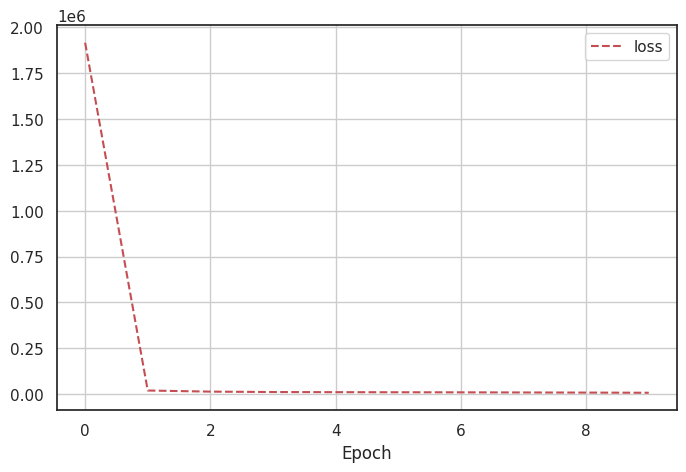

In [ ]:
hist.plot(figsize=(8,5), grid=True, xlabel='Epoch', style=['r--', 'r--.', 'b-', 'b-*'])

plt.show()

---
## 7. What Learning Means in Deep Learning

### Revisited: What is Learning?

How do neural networks actually **learn** their weights?  

At the core, learning is about solving an optimization problem:

$$
\min_w L(w)
$$

where \( L(w) \) is the **loss function**, which measures the average prediction error across the dataset.  
The parameters \( w \) (weights and biases) are adjusted to minimize this loss.

### A Naïve Approach
One brute-force way to solve this problem would be:
1. Start with an initial guess for the weights (e.g., all zeros or small random values).  
2. For a large number of rounds:
   - Randomly choose a new set of weights.  
   - Evaluate performance by computing the loss.  
   - If the new weights reduce the loss, keep them; otherwise discard and try again.  

This method would eventually find the optimal solution, but it is **extremely inefficient**.  
For high-dimensional problems (like neural networks with thousands or millions of parameters), it becomes practically impossible.


### Toward Smarter Alternatives
Instead of blind guessing, modern learning algorithms use:
- **Gradients (derivatives of the loss function)** to understand in which direction to adjust the weights.  
- **Iterative optimization methods** (e.g., gradient descent) to gradually move closer to the optimal weights.  

This makes learning **systematic and efficient**, allowing neural networks to scale to complex real-world problems.

---
## 8. Intro to Gradient Descent Methods

The classical way to solve linear regression is through **matrix methods** (normal equations).  
However, in neural networks this becomes infeasible — we can’t efficiently solve for:

$$
\nabla_w L(w) = 0
$$  

because the loss surface is often high-dimensional and non-convex.

### Key Idea
- The **loss function** $ L(w) $ measures the average prediction error given parameters $ w $.  
- Its **gradient** $ \nabla L(w) $ tells us how the error changes if we tweak the parameters slightly.  

Instead of solving equations directly, we can **iteratively improve** our parameters using **Gradient Descent**.


### Gradient Descent Algorithm
1. **Initialize weights**  
   Start with an initial guess:  
   $$
   w^{(0)}
   $$

2. **Compute direction of steepest descent**  
   This is given by the negative gradient:  
   $$
   -\nabla L(w^{(0)})
   $$

3. **Update weights**  
   Take a step in the direction of steepest descent. The step size is controlled by the learning rate \( \eta \):  
   $$
   w^{(1)} = w^{(0)} - \eta \nabla L(w^{(0)})
   $$

4. **Repeat**  
   Continue this process iteratively:  
   $$
   w^{(t+1)} = w^{(t)} - \eta \nabla L(w^{(t)})
   $$  
   until the loss stops decreasing significantly (convergence).

### Intuition
- Gradient descent **measures the effect of small weight changes on loss**,  
- then adjusts weights slightly to reduce loss,  
- and repeats until improvement stalls.  

The result is an estimate of the optimal weights:  
$$
\hat{w}^\* \approx \arg \min_w L(w)
$$

This is the foundation of how neural networks "learn" in practice.

---
## 9. Demand Prediction Model

To start, we apply a **linear transformation** to the original data $X$ using the **Principal Components Algorithm (PCA)**.  
This gives us transformed features:

$$
\tilde{X}_{PC}
$$

which we hope provide a more efficient representation of the data, making it easier to extract the signals that predict demand.


### Linear Regression Model

With these transformed features, we define a **linear regression model**:

$$
\hat{y} = \tilde{X}_{PC} \, \hat{w}
$$

where:
- $\tilde{X}_{PC}$ = transformed features from PCA,  
- $\hat{w}$ = learned weights,  
- $\hat{y}$ = predicted demand (weekly sales).

In [ ]:
# We will build a simple model (single layers perceptron) since we are building the "training loop" manually (rather than calling .fit())
# This describes what the model consists of
# and defines the FORWARD PASS function (i.e. inputs -> output <=> function evaluation)

model = tf.keras.Sequential([tf.keras.layers.InputLayer(shape=(X_train_PC_codings.shape[1],)),
                             tf.keras.layers.Normalization(axis=-1), # When -1 the last axis of the input is assumed to be a feature dimension and is normalized per index.
                             tf.keras.layers.Dense(1, activation='linear')])

# Weights of model will be the trainable params of the sequential model

### Training the Model

Before we can use this model for predictions, we need to **train it**.  
That means finding weights $\hat{w}$ that minimize the average error between predictions and actual demand.

We do this using **Gradient Descent**, which iteratively updates weights to reduce the loss function.  
Here, I'd like to **implement the gradient descent training loop from scratch**, rather than relying on built-in libraries.

### Building a Custom Training Loop with TensorFlow

A **training loop** iteratively updates model weights to reduce the average prediction error (loss).  
Formally, we aim to solve:
$$
\min_{w} \; L(w; \mathcal{D})
$$

#### Core Steps (per epoch)
1. Iterate over the training data in **mini-batches** (e.g., 32 samples).  
2. **Forward pass:** compute predictions for the batch.  
3. **Loss:** compute average error between predictions and targets.  
4. **Backprop:** compute gradients of the loss w.r.t. weights.  
5. **Update:** apply the optimizer’s update rule to move weights and reduce loss.  
6. Repeat for multiple **epochs** until convergence.

> Time-series note: avoid random shuffling across time; keep sequences intact or use causal windows.

We will implement batch training rather than mini-batch training, which means we'll run each training step (gradient computation and weight update) for ALL the data. This means each training step will take longer to run since we'll compute the FORWARD PASS and  GRADIENTS for all the samples at once. Each gradient update will be much more effective at reducing the loss on the training data, since it has information from all training samples instead of a random sample of, say 32 data points in a batch. This means we need much fewer steps of training and we should use a larger learning rate than one would use for mini-batch training


In [ ]:
# Set hyperparameters for the training loop

learning_rate =  0.1 # step size when updating the weights with batch GD  # 0.01 # step size when updating the weights with mini-batch SGD

num_epochs = 100 # number of times GD passes through the full training data
batch_size = len(X_train_PC_codings)
num_steps = len(X_train_PC_codings)//batch_size

In [ ]:
# Create a function that will randomly sample a batch of instances from the training set
# (this can be replaced with tools from the tf.data API)

def random_batch_index(data, batch_size):
  index = np.random.randint(len(data), size=batch_size) # create random index to sample from X
  return index

In [ ]:
##############################################################################################################################################
## Building a simple custom training loop for batch gradient descent of a single-layer perceptron with linear activation neural network
##############################################################################################################################################
%%time

losses = []

# Epochs loop
for epoch in range(num_epochs):

  # Stepping through batches within the epoch
  for step in range(num_steps):
    # sample a random batch from the training set
    # batch_index = random_batch_index(X_train_PC_codings, batch_size=batch_size)

    X_batch = tf.Variable(X_train_PC_codings, dtype=tf.float32) # X_train_PC_codings[batch_index]
    Y_batch = tf.Variable(Y_train, dtype=tf.float32) # Y_train.iloc[batch_index]

    # Gradient block
    # Define the training / estimation step, i.e. the optimization problem using gradient descent
    # i.e. define the BACKWARD PASS function (outputs -> inputs <=> chain rule differentiation to compute gradient)
    with tf.GradientTape() as tape:
      # Record predictions and loss on the tape
      Y_hat_batch = model(X_batch, training=True) # do not forget to set training=True
                  # training=True: The layer will normalize its inputs using the mean and variance of the current batch of inputs.
      # Define the loss function that we will use to do the BACKWARD PASS and that we use to evaluate each sample's contribution to the total error
      loss = tf.reduce_mean(tf.square(Y_batch - Y_hat_batch)) # tf.reduce_mean(loss_fn(y_batch, y_pred))
    # import pdb; pdb.set_trace()
    # Use the "tape" to compute the gradients of the loss w.r.t. to each TRAINABLE variable as opposed to all variables
    gradients = tape.gradient(loss, model.trainable_variables)
    # Gradients are exploding, so we need to clip the gradients;
    # Clip-by-norm
    gradients = [(tf.clip_by_norm(grad, clip_norm=100.0)) for grad in gradients]
    print(gradients)

    # Implement the gradient descent update W = W - grad_loss_wrt_W * learning_rate
    model.trainable_variables[0].assign_sub(learning_rate * gradients[0]) # equivalent to W = W - grad_loss_wrt_W * learning_rate
    # Implement the gradient descent update bias = bias - grad_loss_wrt_bias * learning_rate
    model.trainable_variables[1].assign_sub(learning_rate * gradients[1]) # equivalent to bias = bias - grad_loss_wrt_bias * learning_rate

    losses.append(loss)

[<tf.Tensor: shape=(15, 1), dtype=float32, numpy=
array([[ 44.26705   ],
       [  0.33076355],
       [ -7.4822845 ],
       [-19.762468  ],
       [  0.31015086],
       [  0.1383179 ],
       [ 61.151905  ],
       [ -0.34988016],
       [-34.7218    ],
       [ -0.1485117 ],
       [-36.825058  ],
       [-35.945454  ],
       [  0.12645184],
       [  0.32756126],
       [  0.2747558 ]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-100.00001], dtype=float32)>]
[<tf.Tensor: shape=(15, 1), dtype=float32, numpy=
array([[-44.267067  ],
       [ -0.33081567],
       [  7.4822855 ],
       [ 19.762478  ],
       [ -0.31014812],
       [ -0.13833244],
       [-61.15195   ],
       [  0.34980804],
       [ 34.72172   ],
       [  0.14856017],
       [ 36.824986  ],
       [ 35.945522  ],
       [ -0.12634821],
       [ -0.32757083],
       [ -0.27477348]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([100.], dtype=float32)>]
[<tf.Tensor: sha

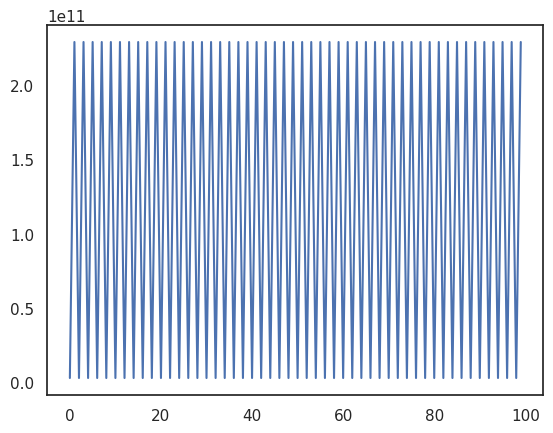

In [ ]:
plt.plot(losses)

In [ ]:
# In order to use Keras' "evaluate" helper function to compute the error,
# we need to compile the model

model.compile(loss="mse")

In [ ]:
# Evaluate our model on the training set and the testing set (now that the model is compiled)

error_on_train_set = model.evaluate(X_train_PC_codings, Y_train)
error_on_test_set = model.evaluate(X_test_PC_codings, Y_test)

print(np.sqrt(error_on_train_set), np.sqrt(error_on_test_set))

9165/9165 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 2536835072.0000
3970/3970 ━━━━━━━━━━━━━━━━━━━━ 3s 877us/step - loss: 2500807168.0000
50754.28998616767 49931.2115615073


#### Reflections on Custom Training Loops  

As we can see, there are many things that we need to get right to customize our own training loop.  
Although our initial implementation may show a significant amount of loss and is clearly not the best practice, it still highlights something important:  

- There is **room to experiment** with different optimization strategies.  
- We have **full control** over the training process, from how gradients are computed to how weights are updated.  
- Even if performance is not optimal at first, the flexibility allows us to explore custom loss functions, learning rate schedules, and domain-specific constraints that may not be possible with built-in methods.  

In short, building our own loop is less about achieving the best results immediately and more about understanding the mechanics of deep learning and laying the groundwork for more advanced experimentation.  


### Training the Model with Adam Optimizer

Instead of implementing a manual gradient descent loop, we can leverage TensorFlow's built-in optimizers and the `fit` method. The Adam optimizer is a popular choice that adaptively adjusts the learning rate during training, which can lead to faster convergence and potentially lower loss.

In [ ]:
# Compile the model with the Adam optimizer
model.compile(optimizer='adam', loss='mse')

# Train the model using the fit method
history_adam = model.fit(X_train_PC_codings, Y_train, epochs=100, verbose=True)

Epoch 1/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 661168512.0000
Epoch 2/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 502543104.0000
Epoch 3/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 502541216.0000
Epoch 4/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 502539328.0000
Epoch 5/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 502537088.0000
Epoch 6/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 502535104.0000
Epoch 7/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 502532960.0000
Epoch 8/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 502530880.0000
Epoch 9/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 502528608.0000
Epoch 10/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 502526368.0000
Epoch 11/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 502524032.0000
Epoch 12/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 502521632.0000
Epoch 13/100
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms

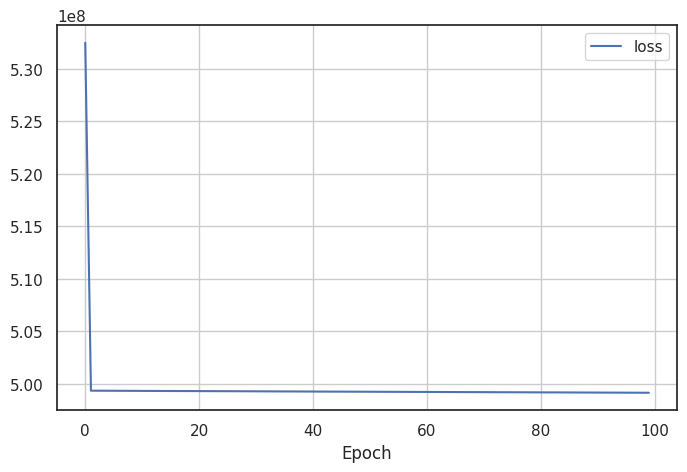

In [ ]:
# Plot the loss
hist_adam = pd.DataFrame(history_adam.history)
hist_adam.plot(figsize=(8,5), grid=True, xlabel='Epoch')
plt.show()

In [ ]:
# Evaluate the model on the training and testing sets
error_on_train_set_adam = model.evaluate(X_train_PC_codings, Y_train)
error_on_test_set_adam = model.evaluate(X_test_PC_codings, Y_test)

print(f"RMSE on training set (Adam): {np.sqrt(error_on_train_set_adam)}")
print(f"RMSE on testing set (Adam): {np.sqrt(error_on_test_set_adam)}")

9165/9165 ━━━━━━━━━━━━━━━━━━━━ 8s 880us/step - loss: 478205088.0000
3970/3970 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1244210048.0000
RMSE on training set (Adam): 22351.443801240224
RMSE on testing set (Adam): 32001.38696994241


### Summary of Gradient Descent Methods  

In this project, I could understand different variations of gradient descent, which is the backbone of training neural networks:  

- **Batch Gradient Descent (GD):**  
  Uses all samples in the training set to update the weights at each iteration. It is stable but computationally expensive, especially for large datasets.  

- **Stochastic Gradient Descent (SGD):**  
  Updates the weights using just one sample at a time. It converges faster but introduces a lot of noise in the optimization path.  

- **Mini-Batch Gradient Descent (SGD with batches):**  
  A compromise between the two: updates weights using small batches of randomly selected samples. It balances stability with efficiency and is the most commonly used approach in deep learning.  

Overall, GD provides precise optimization, but SGD and mini-batch SGD are much more practical for large-scale problems.  


---

## Reflections and Conclusion  

Even though the model in this project performed poorly (with high loss and RMSE), the goal was not solely to achieve state-of-the-art predictive accuracy. Instead, this notebook demonstrated:  

- How to frame **demand prediction** as a supervised learning problem.  
- How to use **feature engineering** (event-based dummies, normalization, PCA) to improve signal extraction.  
- How to implement **neural networks** starting from simple perceptrons to more flexible architectures.  
- How to understand and experiment with **training loops** and **gradient descent methods**.  

This project highlights the **core concepts of deep learning applied to forecasting problems** like retail demand.  
While the first results are not optimal, they provide a solid foundation for future experimentation — such as tuning hyperparameters, testing more complex architectures, and incorporating additional features.  

The key takeaway is that **neural networks, perceptrons, and gradient-based learning offer powerful tools for modeling complex, nonlinear relationships in data**. Even with noisy and challenging datasets like Walmart sales, these methods provide a path toward building models that can capture demand patterns and inform better business decisions.  